In [1]:
import torch
from kernels.grammar import generate_kernel_set
from kernels.builders import build_module
from distances.expectations import expected_sqrtjs_distance_squared
from embedding.mds import mds_from_squared_distance
from analysis.diagnostics import mds_reconstruction_error, parity_metrics
from io_utils.export import export_kernel_embedding

# ─────────────────────────────────────────────────────────────
# Global settings
# ─────────────────────────────────────────────────────────────
torch.set_default_dtype(torch.double)
torch.manual_seed(0)

# Reference input locations
X_ref = torch.linspace(0, 1, 20).unsqueeze(-1)

# ─────────────────────────────────────────────────────────────
# Kernel grammar
# ─────────────────────────────────────────────────────────────
kernel_exprs = generate_kernel_set(max_depth=2)
n = len(kernel_exprs)

print(f"Generated {n} kernels")

# ─────────────────────────────────────────────────────────────
# Pairwise kernel distance matrix (D = (√JS)² = JS)
# ─────────────────────────────────────────────────────────────
D = torch.zeros(n, n)

for i in range(n):
    for j in range(i + 1, n):
        ki = lambda: build_module(kernel_exprs[i])
        kj = lambda: build_module(kernel_exprs[j])

        D[i, j] = D[j, i] = expected_sqrtjs_distance_squared(
            ki, kj, X_ref, n_samples=128
        )

Generated 237 kernels


C:\Users\shafiq\Desktop\kernels-BO\distances\js.py:19: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return float(0.5 * (kl_pm + kl_qm))


Total elements extracted: 28203
Sample values: [0.         0.01368692 0.01463595 0.02126692 0.06278572]


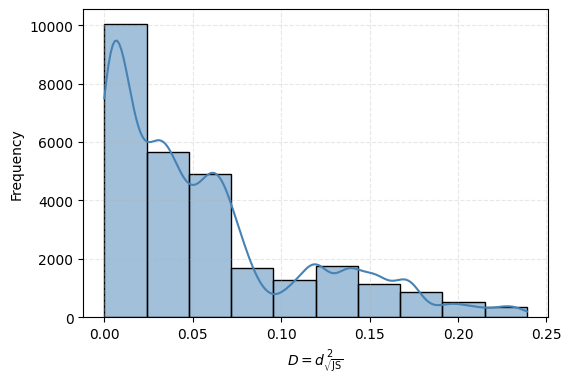

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

D20_np = D.detach().cpu().numpy() if "torch" in str(type(D)) else np.array(D20)

# Extract upper triangular including diagonal (k=0)
utri_vals = D20_np[np.triu_indices_from(D20_np, k=0)]

print(f"Total elements extracted: {len(utri_vals)}")
print("Sample values:", utri_vals[:5])

# ─── Plot Distribution ──────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
sns.histplot(utri_vals, bins=10, kde=True, color="steelblue", edgecolor="black")
plt.xlabel(r"$D = d_{\sqrt{\mathrm{JS}}}^{\,2}$")
plt.ylabel("Frequency")
plt.grid(alpha=0.3, linestyle="--")
plt.show()


In [3]:
import torch

from kernels.grammar import generate_kernel_set
from kernels.builders import build_module
from distances.expectations import expected_sqrtjs_distance_squared

from embedding.mds import mds_from_squared_distance
from analysis.diagnostics import (
    plot_mds_error_vs_k,
    plot_mds_parity,
    mds_reconstruction_error,
    parity_metrics,
)
from io_utils.export import export_kernel_embedding

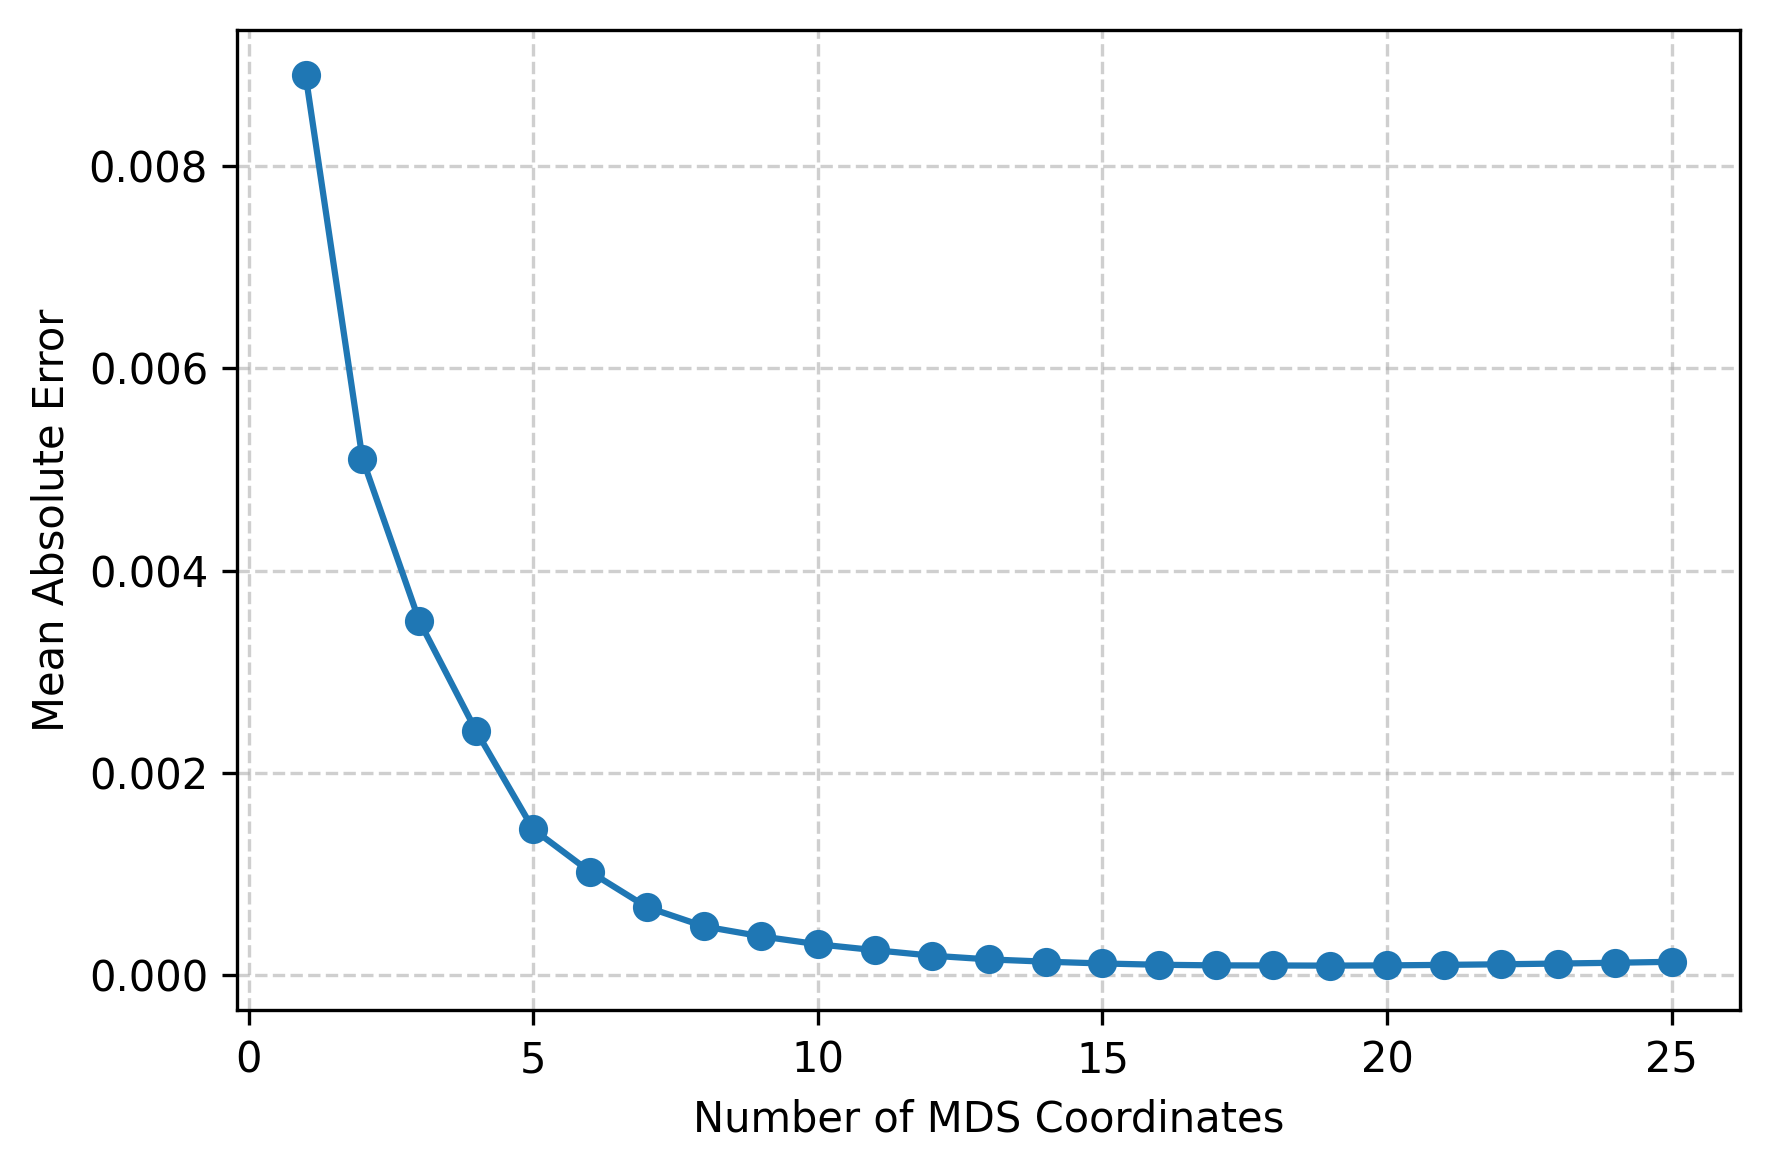

In [6]:
# ─────────────────────────────────────────────────────────────
# Diagnostics & plots
# ─────────────────────────────────────────────────────────────


# 1) Reconstruction error vs dimension
plot_mds_error_vs_k(D, k_max=25, save_path="output/mds_error_vs_k.pdf")



MDS mean abs error     : 1.181e-04
MDS relative error     : 2.075e-03
Parity R² / RMSE / MAE : 0.9999, 0.0009, 0.0005


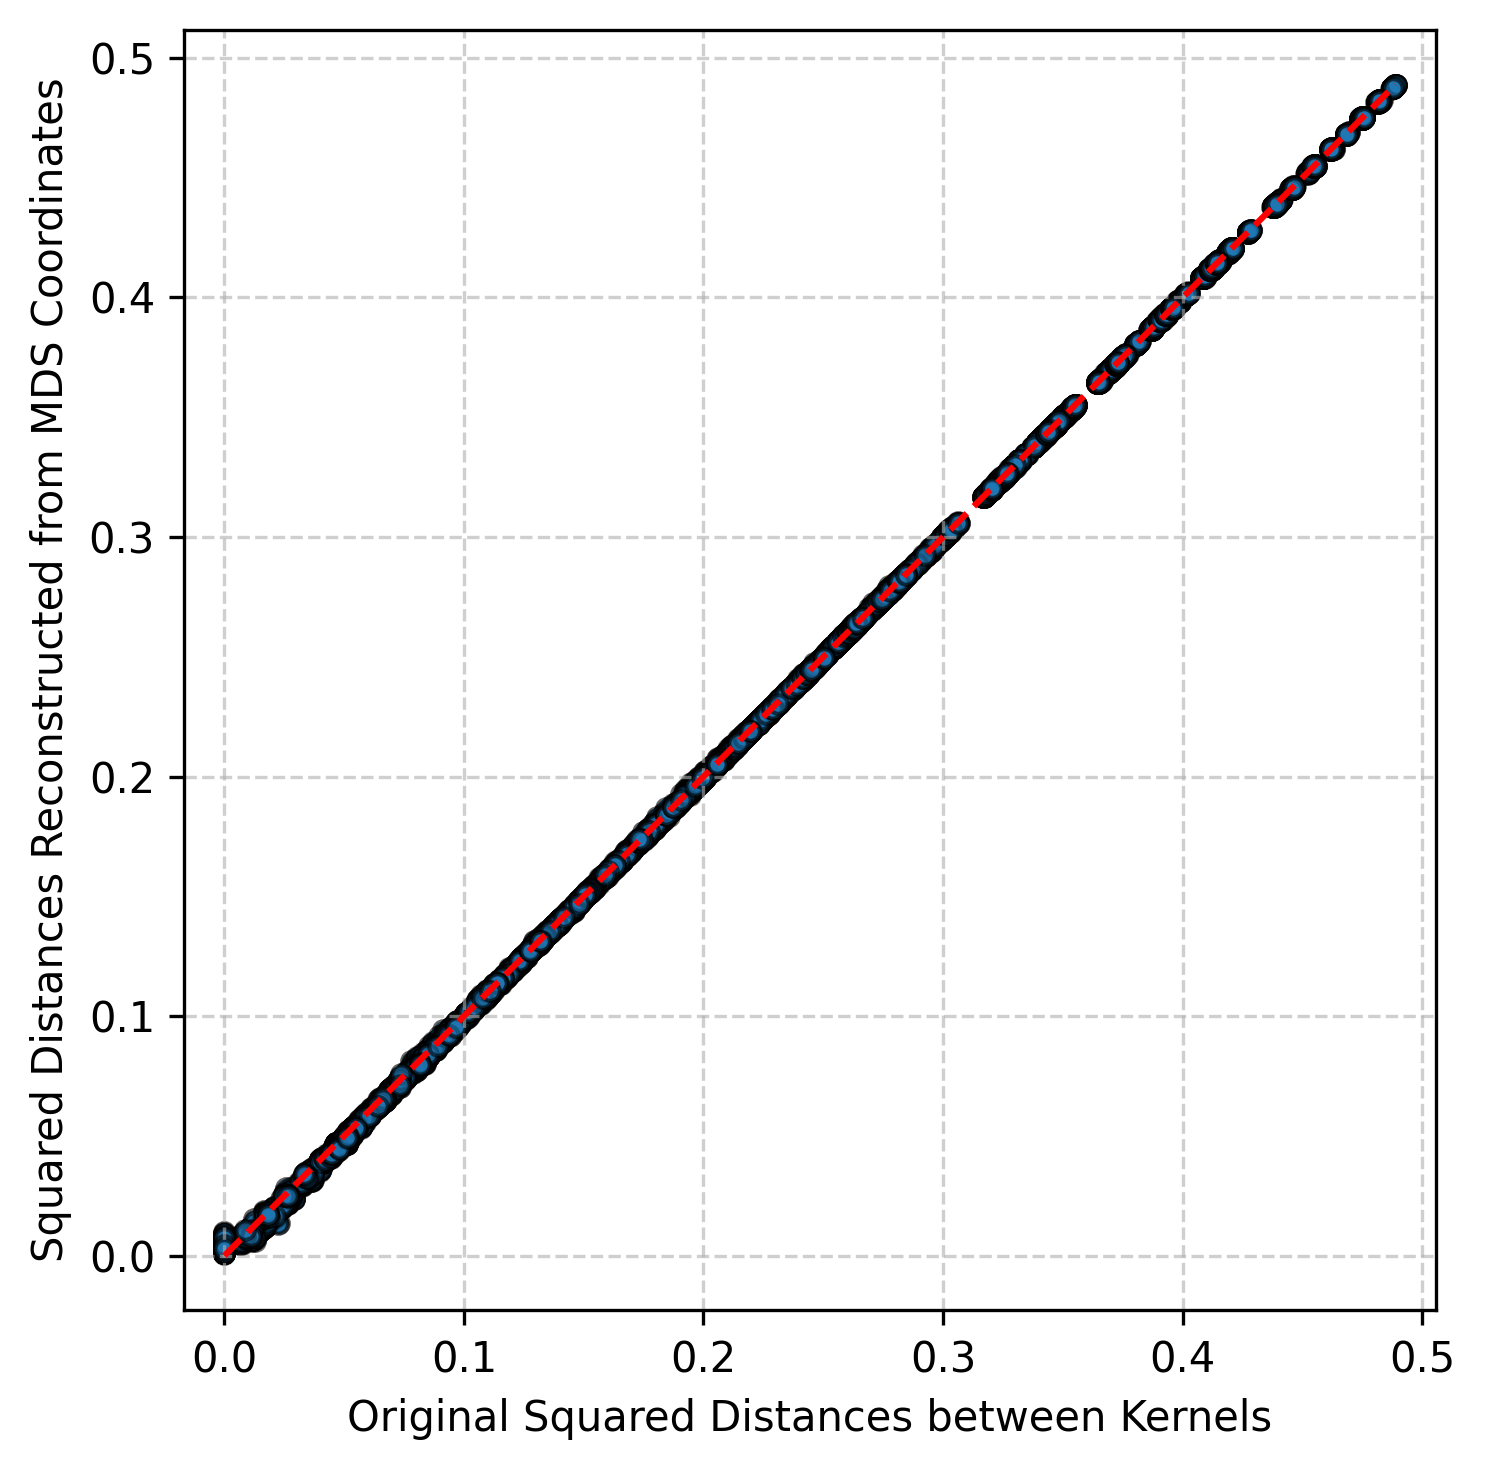

In [7]:
# ─────────────────────────────────────────────────────────────
# MDS embedding
# ─────────────────────────────────────────────────────────────
X_feat, evals = mds_from_squared_distance(D, k=15)

# ─────────────────────────────────────────────────────────────
# Diagnostics
# ─────────────────────────────────────────────────────────────
err, rel = mds_reconstruction_error(D, X_feat)
r2, rmse, mae = parity_metrics(D, X_feat)

print(f"MDS mean abs error     : {err:.3e}")
print(f"MDS relative error     : {rel:.3e}")
print(f"Parity R² / RMSE / MAE : {r2:.4f}, {rmse:.4f}, {mae:.4f}")

# Parity plot (original vs reconstructed distances)
plot_mds_parity(D, X_feat, save_path="output/mds_parity.pdf")

# ─────────────────────────────────────────────────────────────
# Export
# ─────────────────────────────────────────────────────────────
export_kernel_embedding(
    X_feat,
    kernel_exprs,
    "output/kernels_JS.csv"
)
